In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from IPython.display import Audio, display
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold, ParameterGrid, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, roc_curve, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

In [6]:
SEED = 3            # semilla para reproductibilidad
SR = 2000           # sampling rate
N_FFT = 256         # tamaño de la ventana
HOP_LENGTH = 63     # salto entre frames
N_MELS = 64         # frequency bins (resolución)
MAX_FREQ = 600      # máxima frecuencia para los espectrogramas

In [7]:
def load_data(train_path:str, test_path:str, labels_path:str, sampling_rate=SR):
    test_files = [f for f in os.listdir(test_path) if f.endswith('.aiff')]
    labels_df = pd.read_csv(labels_path)

    audio_df = labels_df.copy()
    audio_df['filepath'] = audio_df['clip_name'].apply(lambda x: os.path.join(train_path, x))
    audio_df['audio'] = audio_df['filepath'].apply(lambda path: librosa.load(path, sr=sampling_rate)[0])

    return audio_df, labels_df, test_files

def display_random_samples(dataset:pd.DataFrame, sampling_rate=SR):
    np.random.seed(SEED)

    # SAMPLES
    whale_sample = dataset[dataset['label'] == 1].sample(5)['audio']
    noise_sample = dataset[dataset['label'] == 0].sample(5)['audio']

    # AUDIO
    print('right whale call random audio sample')
    display(Audio(np.array(whale_sample.iloc[0]), rate=sampling_rate*1.5))
    print('\nno whale random audio sample')
    display(Audio(np.array(noise_sample.iloc[0]), rate=sampling_rate*1.5))

    # SOUND-WAVE
    fig, axes = plt.subplots(2, 5, figsize=(15, 5))

    for i in range(5):
        axes[0, i].plot(np.array(whale_sample.iloc[i]))
        axes[0, i].set_title('Whale')
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])

        axes[1, i].plot(np.array(noise_sample.iloc[i]), color='#FF6961')
        axes[1, i].set_title('No Whale')
        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])

    plt.tight_layout()
    plt.show()

    # MULTIPLE SPECTROGRAMS
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    for i in range(5):
        whale_sample_spectrogram = get_melspectrogram(whale_sample.iloc[i])
        img0 = librosa.display.specshow(whale_sample_spectrogram, sr=sampling_rate, hop_length=HOP_LENGTH, ax=axes[0, i], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
        axes[0, i].set_title('Whale')
        axes[0, i].set_ylim([0, MAX_FREQ])
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])
        axes[0, i].set_xlabel('')
        axes[0, i].set_ylabel('')

        noise_sample_spectrogram = get_melspectrogram(noise_sample.iloc[i])
        img1 = librosa.display.specshow(noise_sample_spectrogram, sr=sampling_rate, hop_length=HOP_LENGTH, ax=axes[1, i], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
        axes[1, i].set_title('No Whale')
        axes[1, i].set_ylim([0, MAX_FREQ])
        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])
        axes[1, i].set_xlabel('')
        axes[1, i].set_ylabel('')

    plt.tight_layout()
    plt.show()

    # TWO SPECTROGRAMS
    whale_sample2 = dataset[dataset['label'] == 1].sample(1, random_state=SEED+1)['audio']
    noise_sample2 = dataset[dataset['label'] == 0].sample(1, random_state=SEED+1)['audio']
    
    fig, axes = plt.subplots(1, 2, figsize=(7, 3))

    whale_sample2_spectrogram = get_melspectrogram(whale_sample2.iloc[0])
    img0 = librosa.display.specshow(whale_sample2_spectrogram, sr=sampling_rate, hop_length=HOP_LENGTH, ax=axes[0], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
    axes[0].set_title('Whale')
    axes[0].set_ylim([0, MAX_FREQ])
    fig.colorbar(img0, ax=axes[0], format="%+2.0f dB")

    noise_sample2_spectrogram = get_melspectrogram(noise_sample2.iloc[0])
    img1 = librosa.display.specshow(noise_sample2_spectrogram, sr=sampling_rate, hop_length=HOP_LENGTH, ax=axes[1], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
    axes[1].set_title('No Whale')
    axes[1].set_ylim([0, MAX_FREQ])
    fig.colorbar(img1, ax=axes[1], format="%+2.0f dB")

    plt.tight_layout()
    plt.show()

def normalize(dataset:pd.DataFrame, column:str):
    dataset[column] = dataset[column].apply(lambda x: x / np.max(np.abs(x)))

def get_signal_energy(dataset:pd.DataFrame, column:str):
    energy = []
    df = dataset.copy()
    for x in df[column]:
        energy.append(np.sum(np.square(x)))
    df['energy'] = energy

    return df

def get_melspectrogram(sample:pd.DataFrame, sampling_rate=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS):
    mel_spectrogram = librosa.feature.melspectrogram(y=np.array(sample), sr=sampling_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=MAX_FREQ)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram

def get_all_mel_spectrograms(audio_df, sampling_rate=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS):
    mel_specs = []
    for audio in audio_df['audio']:
        mel = get_melspectrogram(audio, sampling_rate, n_fft, hop_length, n_mels)
        mel_specs.append(mel.flatten())
    return np.array(mel_specs)

def show_class_balance(dataset:pd.DataFrame):
    plt.figure(figsize=(5, 4))
    ax = sns.countplot(
        x='label',
        data=dataset,
        palette={0: '#FF6961', 1: plt.rcParams['axes.prop_cycle'].by_key()['color'][0]},
        hue='label',
        legend=False
    )
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Noise', 'Whale'])
    ax.legend(['Noise', 'Whale'], title='Class')
    plt.show()

def extract_time_acoustic_features(dataset:pd.DataFrame):
    new_features = []
    for audio in dataset['audio']:
        audio_np = np.array(audio)
        acoustic_features = {
            'rms_energy': np.mean(librosa.feature.rms(y=audio_np)),
            'zcr': np.mean(librosa.feature.zero_crossing_rate(y=audio_np)),
        }
        new_features.append(acoustic_features)
    features_df = pd.DataFrame(new_features)
    return features_df

def extract_frequency_acoustic_features(dataset:pd.DataFrame):
    new_features = []
    for audio in dataset['audio']:
        audio_np = np.array(audio)
        acoustic_features = {
            'spectral_centroid': np.mean(librosa.feature.spectral_centroid(y=audio_np)),
            'spectral_bandwidth': np.mean(librosa.feature.spectral_bandwidth(y=audio_np)),
            'spectral_rolloff': np.mean(librosa.feature.spectral_rolloff(y=audio_np)),
            'spectral_flatness': np.mean(librosa.feature.spectral_flatness(y=audio_np))
        }
        new_features.append(acoustic_features)
    features_df = pd.DataFrame(new_features)
    return features_df

def extract_acoustic_features(dataset:pd.DataFrame):
    time_features = extract_time_acoustic_features(dataset)
    frequency_features = extract_frequency_acoustic_features(dataset)

    new_df = pd.concat([dataset.reset_index(drop=True), time_features], axis=1)
    new_df = pd.concat([new_df.reset_index(drop=True), frequency_features], axis=1)
    
    return new_df

def display_features_boxplots(audio_features_df:pd.DataFrame):
    time_features = ['rms_energy', 'zcr']
    freq_features = ['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'spectral_flatness']

    # TIME
    fig, axes = plt.subplots(1, len(time_features), figsize=(5 * len(time_features), 5))
    if len(time_features) == 1:
        axes = [axes]
    for i, feature in enumerate(time_features):
        sns.boxplot(x='label', y=feature, data=audio_features_df, ax=axes[i], showfliers=False)
        axes[i].set_title(f'{feature} by Class')
        axes[i].set_xlabel('Class')
        axes[i].set_xticks([0, 1])
        axes[i].set_xticklabels(['Noise', 'Whale'])

    plt.suptitle('Time Domain Features by Class')
    plt.tight_layout()
    plt.show()

    # FREQUENCY
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()
    for i, feature in enumerate(freq_features):
        sns.boxplot(x='label', y=feature, data=audio_features_df, ax=axes[i], showfliers=False)
        axes[i].set_title(f'{feature} by Class')
        axes[i].set_xlabel('Class')
        axes[i].set_xticks([0, 1])
        axes[i].set_xticklabels(['Noise', 'Whale'])

    plt.suptitle('Frequency Domain Features by Class')
    plt.tight_layout()
    plt.show()

def plot_pca(dataset:pd.DataFrame, pca_arr):
    plt.figure(figsize=(8,6))
    scatter = sns.scatterplot(
        x=pca_arr[:,0], 
        y=pca_arr[:,1], 
        hue=dataset['label'], 
        palette={0: '#FF6961', 1: '#1f77b4'}
    )
    plt.title('PCA of Mel Spectrograms')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    # Fix legend labels and colors
    handles, _ = scatter.get_legend_handles_labels()
    scatter.legend(handles=handles, title='Class', labels=['Noise', 'Whale'])
    plt.show()

def plot_average_spectrograms(audio_df:pd.DataFrame):
    whale_spectrograms = []
    noise_spectrograms = []
    for audio, label in zip(audio_df['audio'], audio_df['label']):
        spectrogram = get_melspectrogram(audio)
        if label == 1:
            whale_spectrograms.append(spectrogram)
        else: 
            noise_spectrograms.append(spectrogram)
    
    whale_spectrograms = np.array(whale_spectrograms)
    noise_spectrograms = np.array(noise_spectrograms)

    whale_average_spectrogram = whale_spectrograms.mean(axis=0)
    noise_average_spectrogram = noise_spectrograms.mean(axis=0)
    average_differences_spectrogram = whale_average_spectrogram - noise_average_spectrogram

    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    img0 = librosa.display.specshow(whale_average_spectrogram, sr=SR, hop_length=HOP_LENGTH, ax=axes[0], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
    axes[0].set_title('Whale Call Average Spectrogram', pad=20)
    axes[0].set_ylim([0, MAX_FREQ])
    # axes[0].set_xticks([])
    # axes[0].set_yticks([])
    fig.colorbar(img0, ax=axes[0], format="%+2.0f dB")

    img1 = librosa.display.specshow(noise_average_spectrogram, sr=SR, hop_length=HOP_LENGTH, ax=axes[1], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
    axes[1].set_title('No Whale Call Average Spectrogram', pad=20)
    axes[1].set_ylim([0, MAX_FREQ])
    # axes[1].set_xticks([])
    # axes[1].set_yticks([])
    fig.colorbar(img1, ax=axes[1], format="%+2.0f dB")

    img2 = librosa.display.specshow(average_differences_spectrogram, sr=SR, hop_length=HOP_LENGTH, ax=axes[2], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
    axes[2].set_title('Average Differences Spectrogram', pad=20)
    axes[2].set_ylim([0, MAX_FREQ])
    # axes[2].set_xticks([])
    # axes[2].set_yticks([])
    fig.colorbar(img2, ax=axes[2], format="%+2.0f dB")

    # 3 subplots -> average spectrogram whale, noise, resto y consigo diferencias
    plt.tight_layout()
    plt.show()

In [8]:
train_dir = 'data/whale-detection-challenge/data/train'
test_dir = 'data/whale-detection-challenge/data/test'
labels_dir = 'data/whale-detection-challenge/data/train.csv'

audio_df, labels_df, test_files = load_data(train_dir, test_dir, labels_dir)

In [9]:
def normalize_spectrogram(spec, global_min, global_max):
    norm_spec = (spec - global_min) / (global_max - global_min + 1e-8)
    return norm_spec

def denormalize_spectrogram(norm_spec, min_val, max_val):
    return norm_spec * (max_val - min_val + 1e-8) + min_val

def compute_global_min_max(audio_df):
    whale_specs = [get_melspectrogram(audio) for audio, label in zip(audio_df['audio'], audio_df['label']) if label == 1]
    global_min = np.min([spec.min() for spec in whale_specs])
    global_max = np.max([spec.max() for spec in whale_specs])
    return global_min, global_max

def get_class_weights(y):
    weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    return torch.tensor(weights, dtype=torch.float32)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score
import copy 

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_layers=[256, 128, 64], output_dim=2):
        super(MLP, self).__init__()
        layers = []
        prev_dim = input_dim

        for hidden_layer in hidden_layers:
            layers.append(nn.Linear(prev_dim, hidden_layer))
            layers.append(nn.ReLU())
            prev_dim = hidden_layer
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)
        self.device = torch.device('mps' if torch.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')

    def forward(self, x):
        return self.model(x)

    def train_model(self, train_loader, val_loader, epochs=50, lr=0.001, weight_decay=1e-5,
                    early_stopping_patience=None, use_class_weights=True):
        self.to(self.device)

        # Loss function
        if use_class_weights:
            y_train = train_loader.dataset.tensors[1].cpu().numpy().flatten()
            weights = get_class_weights(y_train).to(self.device)
            loss_function = nn.CrossEntropyLoss(weight=weights)
        else:
            loss_function = nn.CrossEntropyLoss()

        optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        train_losses = []
        val_losses = []

        best_val_f1 = 0.0
        best_model_state = None
        patience_counter = 0

        for epoch in range(epochs):
            self.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)

            avg_train_loss = running_loss / len(train_loader.dataset)
            train_losses.append(avg_train_loss)

            val_loss, val_acc, val_f1, val_auc = self.evaluate(val_loader, return_metrics=True)
            val_losses.append(val_loss)

            print(f'Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | '
                f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val F1: {val_f1:.4f} | Val AUC: {val_auc:.4f}')

            # Early stopping con F1
            if early_stopping_patience is not None:
                if val_f1 > best_val_f1:
                    best_val_f1 = val_f1
                    best_model_state = copy.deepcopy(self.state_dict())
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= early_stopping_patience:
                        print("Early stopping triggered (F1 no mejoró).")
                        break

        # Restaurar el mejor modelo
        if best_model_state is not None:
            self.load_state_dict(best_model_state)

        return train_losses, val_losses


    from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

    def evaluate(self, val_loader, return_metrics=False):
        self.eval()
        val_loss = 0.0
        all_labels = []
        all_probs = []
        all_preds = []

        loss_function = nn.CrossEntropyLoss()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self(inputs)
                loss = loss_function(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                probs = torch.softmax(outputs, dim=1)[:, 1]
                preds = torch.argmax(outputs, dim=1)

                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader.dataset)
        acc = accuracy_score(all_labels, all_preds)
        try:
            auc = roc_auc_score(all_labels, all_probs)
        except ValueError:
            auc = 0.0  # puede fallar si hay una sola clase
        f1 = f1_score(all_labels, all_preds)

        if return_metrics:
            return avg_val_loss, acc * 100, f1, auc

        print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {acc * 100:.2f}%, F1: {f1:.4f}, AUC: {auc:.4f}')

In [11]:
audio_train_df = audio_df[audio_df['clip_name'].str.contains('train')]
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f'Using device: {device}')

Using device: mps


#### MLP

In [12]:
X = get_all_mel_spectrograms(audio_train_df)
y = audio_train_df['label'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

batch_size = 128
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)

In [13]:
mlp_torch = MLP(X_train.shape[1])
mlp_torch.to(device)
train_losses, val_losses = mlp_torch.train_model(train_loader, val_loader, epochs=30, lr=1e-4)

Epoch 1/30 | Train Loss: 0.4336 | Val Loss: 0.5370 | Val Acc: 76.93% | Val F1: 0.6621 | Val AUC: 0.9102
Epoch 2/30 | Train Loss: 0.3672 | Val Loss: 0.3812 | Val Acc: 83.83% | Val F1: 0.7251 | Val AUC: 0.9211
Epoch 3/30 | Train Loss: 0.3453 | Val Loss: 0.3364 | Val Acc: 85.37% | Val F1: 0.7365 | Val AUC: 0.9267
Epoch 4/30 | Train Loss: 0.3326 | Val Loss: 0.3000 | Val Acc: 86.05% | Val F1: 0.6557 | Val AUC: 0.9300
Epoch 5/30 | Train Loss: 0.3241 | Val Loss: 0.3606 | Val Acc: 84.00% | Val F1: 0.7336 | Val AUC: 0.9338
Epoch 6/30 | Train Loss: 0.3137 | Val Loss: 0.3595 | Val Acc: 84.85% | Val F1: 0.7423 | Val AUC: 0.9352
Epoch 7/30 | Train Loss: 0.3075 | Val Loss: 0.3205 | Val Acc: 85.48% | Val F1: 0.7454 | Val AUC: 0.9374
Epoch 8/30 | Train Loss: 0.3037 | Val Loss: 0.3270 | Val Acc: 86.20% | Val F1: 0.7542 | Val AUC: 0.9355
Epoch 9/30 | Train Loss: 0.3079 | Val Loss: 0.2634 | Val Acc: 87.60% | Val F1: 0.7078 | Val AUC: 0.9417
Epoch 10/30 | Train Loss: 0.2922 | Val Loss: 0.4507 | Val Acc: 8

In [14]:
mlp_torch.evaluate(val_loader)

Validation Loss: 0.3581, Accuracy: 84.18%, F1: 0.7381, AUC: 0.9449


#### VAE

In [15]:
# VARIATIONAL AUTOENCODER MODEL

class BetaVAE(nn.Module):
    def __init__(self, latent_dim=32):
        super(BetaVAE, self).__init__()

        # Encoder
        self.enc = nn.Sequential(
            # (1, 64, 64) -> (32, 32, 32)
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # (32, 32, 32) -> (64, 16, 16)
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # (64, 16, 16) -> (128, 8, 8)
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # (128, 8, 8) -> (256, 4, 4)
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)

        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 256 * 4 * 4)
        self.dec = nn.Sequential(
            # (256, 4, 4) -> (128, 8, 8)
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # (128, 8, 8) -> (64, 16, 16)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # (64, 16, 16) -> (32, 32, 32)
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # (32, 32, 32) -> (1, 64, 64)
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            # Sin activación final para MSE loss (usá Sigmoid para [0,1])
        )

    def encode(self, x):
        h = self.enc(x)
        h = h.view(h.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z).view(-1, 256, 4, 4)
        return self.dec(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar
        
    def bvae_loss(self, recon_x, x, mu, logvar, beta=1.0):
        recon_loss = F.mse_loss(recon_x, x, reduction='sum')
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + beta * kld_loss, recon_loss, kld_loss


In [16]:
whale_audios = audio_df[audio_df['label'] == 1]

In [17]:
mel_specs = []
for whale_audio in whale_audios['audio']:
    mel = get_melspectrogram(whale_audio) # shape: (64, 64)
    mel = mel[np.newaxis, :, :] # shape: (1, 64, 64)
    mel_specs.append(mel)

In [18]:
X = np.array(mel_specs)
global_mean = X.mean()
global_std = X.std()
X = (X - global_mean) / (global_std + 1e-8)

print(f'Global mean: {global_mean}, Global std: {global_std}')
print(f'Shape of X: {X.shape}')

Global mean: -21.893871307373047, Global std: 11.335022926330566
Shape of X: (7027, 1, 64, 64)


In [19]:
def load_model(path="saved_models/bvae.pt"):
    device = torch.device("mps" if torch.mps.is_available() else "cpu")
    model = BetaVAE().to(device)
    state_dict = torch.load(path, map_location=device, weights_only=True)
    model.load_state_dict(state_dict)
    model.eval()
    print(f"[✔] Modelo cargado desde: {path}")
    return model

BVAE = load_model()

[✔] Modelo cargado desde: saved_models/bvae.pt


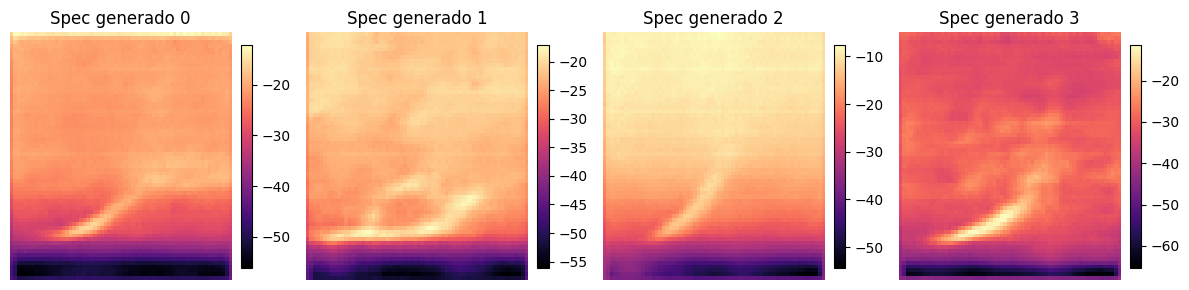

In [20]:
latent_dim = 32

with torch.no_grad():
    # 1. Generá un batch de vectores latentes Z ~ N(0, I)
    z_samples = torch.randn(4, latent_dim).to(device)  # Por ejemplo, 4 muestras
    # 2. Decodificá los Z para obtener espectrogramas
    generated_specs = BVAE.decode(z_samples)

# Ahora `generated_specs` es un tensor de shape [4, 1, 64, 64]

generated_specs = generated_specs.cpu().numpy()

fig, axes = plt.subplots(1, generated_specs.shape[0], figsize=(3 * generated_specs.shape[0], 3))
for i in range(generated_specs.shape[0]):
    spec = generated_specs[i, 0, :, :]
    spec = spec * global_std + global_mean
    ax = axes[i] if generated_specs.shape[0] > 1 else axes
    im = ax.imshow(spec, aspect='auto', origin='lower', cmap='magma')
    ax.set_title(f"Spec generado {i}")
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

#### DATA AUGMENTATION

In [21]:
datos_totales = len(y_train)
audios_ballena = np.count_nonzero(y_train)
audios_ruido = datos_totales - audios_ballena
ballenas_faltantes = audios_ruido - audios_ballena

print(f'De los {datos_totales} datos que se usan para entrenar: {audios_ballena} son de ballena y {audios_ruido} son de ruido, por ende falta completar con {ballenas_faltantes} audios de ballena.')

De los 24000 datos que se usan para entrenar: 5622 son de ballena y 18378 son de ruido, por ende falta completar con 12756 audios de ballena.


In [22]:
print(f'X_train shape: {(X_train.shape)}')
print(f'y_train shape: {(y_train.shape)}')

X_train shape: (24000, 4096)
y_train shape: (24000,)


In [23]:
# Generate new whale samples using the trained BVAE
n_new_samples = ballenas_faltantes  # 12756

# Generate latent vectors
z_new = torch.randn(n_new_samples, latent_dim).to(device)

# Decode to spectrograms
with torch.no_grad():
    generated_specs = BVAE.decode(z_new).cpu().numpy()  # shape: (n_new_samples, 1, 64, 64)

# Remove channel dimension and destandardize
generated_specs = generated_specs[:, 0, :, :]  # shape: (n_new_samples, 64, 64)
generated_specs = generated_specs * global_std + global_mean

# Flatten to match X_train shape
generated_specs_flat = generated_specs.reshape(n_new_samples, -1)

# Concatenate to X_train and y_train
X_train_aug = np.concatenate([X_train, generated_specs_flat], axis=0)
y_train_aug = np.concatenate([y_train, np.ones(n_new_samples, dtype=int)], axis=0)

In [24]:
print(f'X_train shape: {(X_train_aug.shape)}')
print(f'y_train shape: {(y_train_aug.shape)}')

X_train shape: (36756, 4096)
y_train shape: (36756,)


In [25]:
X_train_aug_tensor = torch.tensor(X_train_aug, dtype=torch.float32)
y_train_aug_tensor = torch.tensor(y_train_aug, dtype=torch.long)

aug_train_loader = DataLoader(TensorDataset(X_train_aug_tensor, y_train_aug_tensor), batch_size=batch_size, shuffle=True)

In [26]:
new_MLP = MLP(X_train_aug.shape[1])
new_MLP.to(device)
aug_train_losses, aug_val_losses = new_MLP.train_model(aug_train_loader, val_loader, epochs=30, lr=1e-4)

Epoch 1/30 | Train Loss: 0.4050 | Val Loss: 0.4210 | Val Acc: 83.12% | Val F1: 0.7227 | Val AUC: 0.9173
Epoch 2/30 | Train Loss: 0.3293 | Val Loss: 0.2995 | Val Acc: 86.88% | Val F1: 0.7518 | Val AUC: 0.9284
Epoch 3/30 | Train Loss: 0.3152 | Val Loss: 0.2983 | Val Acc: 87.08% | Val F1: 0.7384 | Val AUC: 0.9270
Epoch 4/30 | Train Loss: 0.3022 | Val Loss: 0.2688 | Val Acc: 87.37% | Val F1: 0.7483 | Val AUC: 0.9370
Epoch 5/30 | Train Loss: 0.2801 | Val Loss: 0.2799 | Val Acc: 87.35% | Val F1: 0.7481 | Val AUC: 0.9359
Epoch 6/30 | Train Loss: 0.2734 | Val Loss: 0.3525 | Val Acc: 85.25% | Val F1: 0.7469 | Val AUC: 0.9356
Epoch 7/30 | Train Loss: 0.2704 | Val Loss: 0.4499 | Val Acc: 79.15% | Val F1: 0.6864 | Val AUC: 0.9368
Epoch 8/30 | Train Loss: 0.2610 | Val Loss: 0.2546 | Val Acc: 88.13% | Val F1: 0.7452 | Val AUC: 0.9434
Epoch 9/30 | Train Loss: 0.2546 | Val Loss: 0.4694 | Val Acc: 82.00% | Val F1: 0.7164 | Val AUC: 0.9348
Epoch 10/30 | Train Loss: 0.2455 | Val Loss: 0.4501 | Val Acc: 8

In [27]:
new_MLP.evaluate(val_loader)

Validation Loss: 0.2713, Accuracy: 87.62%, F1: 0.7361, AUC: 0.9402
